<a href="https://colab.research.google.com/github/BenYavor/Autoencoder_communication_sytem_with_GAN_channel-estimation/blob/master/Communication_Autoencoder_with_GAN_alternating_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt   
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import tensorflow as tf
import os
tf.__version__
from tensorflow import keras
import time
from __future__ import absolute_import, division, print_function, unicode_literals
import pandas as pd
import sys
assert sys.version_info >= (3, 5)
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from scipy import special
from tensorflow.keras import layers
np.random.seed(42)
tf.random.set_seed(42)

#### Vergleich
Als erstes für feste $k$ und $n$, was sich ändert ist die Samplesize, Anzahl der Samples und SNR

###Systemparameter
ACHTUNG: CHANNELANZAHL WURDE UNTERSCHIEDLICH VERWENDET \\
$k$ - die Anzhal der bits \\
$M$ - Anzahl der unterschiedlichen Nachrichten \\
$n$ - channel uses\\
$N$ - Länge des Rauschvektors

In [2]:
k = 4      # Number of information bits per message, i.e., M=2**k
M = 2**k
n = 2    # Number of real channel uses per message
#k = int(np.log2(M))
#n = 2
print(M)

SNR = 7


16


## Training Parameter

In [0]:
gen_learning_rate=0.0001 
disc_learning_rate = 0.0001                  # 0.0001  

### Different Layers

In [0]:
randN_initial = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
ones_initial = keras.initializers.GlorotNormal()

EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(2*n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
# = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


#noise_std = EbNo_to_noise(TRAINING_SNR)
# custom functions / layers without weights
norm_layer = keras.layers.Lambda(lambda x: tf.divide(x,tf.sqrt(2*tf.reduce_mean(tf.square(x)))))
shape_layer = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,2,n]))
shape_layer2 = keras.layers.Lambda(lambda x: tf.reshape(x, shape=[-1,n]))
channel_layer = keras.layers.Lambda(lambda x: x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))

### Help functions

In [5]:
def EbNo2Sigma(ebnodb):
    '''Convert Eb/No in dB to noise standard deviation'''
    ebno = 10**(ebnodb/10)
    return 1/np.sqrt(2*(2*k/n)*ebno)

def EbNo_to_noise(ebnodb):
    '''Transform EbNo[dB]/snr to noise power'''
    ebno = 10**(ebnodb/10)
    noise_std = 1/np.sqrt(2*(2*k/n)*ebno) 
    return noise_std


def real_channel(x,noise_std):
    # Black-box Channel
    #AWGN
    return x + tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)

def rayleigh_channel(x,noise_std):
    return x + tf.sqrt(tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)) + tf.square(tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)))
    
    #Uniform U(-3;3)    
    #return x + tf.random_uniform(tf.shape(x), minval=-2, maxval=2)

def B_Ber(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(tf.argmax(msg, 1), tf.argmax(input_msg, 1))
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def random_sample(batch_size=32):
    msg = np.random.randint(M, size=batch_size)
    return msg




def B_Ber_m(input_msg, msg):
    '''Calculate the Batch Bit Error Rate'''
    pred_error = tf.not_equal(input_msg, tf.argmax(msg, 1))      
    bber = tf.reduce_mean(tf.cast(pred_error, tf.float32))
    return bber

def SNR_to_noise(snrdb):
    '''Transform EbNo[dB]/snr to noise power'''
    snr = 10**(snrdb/10)
    noise_std = 1/np.sqrt(2*snr)
    return noise_std

noise_std = EbNo2Sigma(SNR)

print(EbNo2Sigma(SNR))
print(EbNo_to_noise(SNR))

0.15792649852735607
0.15792649852735607


In [0]:
def test_encoding(M=16, n=1):
    inp = np.arange(0,M)
    coding = encoder.predict(inp)
    fig = plt.figure(figsize=(4,4))
    plt.plot(coding[:,0], coding[:, 1], "b.")
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18, rotation=0)
    plt.grid(True)
    plt.gca().set_ylim(-2, 2)
    plt.gca().set_xlim(-2, 2)
    plt.show()
  


# Models

#### Generator Model

In [0]:
def get_generator(n):
  input1 = tf.keras.layers.Input(shape=(n,))
  x1 = tf.keras.layers.Dense(n,kernel_initializer=randN_initial)(input1)
  input2 =tf.random.normal(shape=tf.shape(input1))
  #input2 =tf.random.normal([tf.shape(input1)[0],n])
  x2 = tf.keras.layers.Dense(n,kernel_initializer=randN_initial)(input2)
  subtracted = tf.keras.layers.Concatenate(1)([x1, x2])
  h1 = tf.keras.layers.Dense(64,use_bias=True,  activation='relu')(subtracted)
  h2 = tf.keras.layers.Dense(64,use_bias=True,kernel_initializer=ones_initial, activation='relu')(h1)
  out = tf.keras.layers.Dense(n, use_bias= True, activation='linear')(h2)
  generator = tf.keras.models.Model(inputs=[input1], outputs=out)
  return generator


#### Discriminator Model 

In [0]:
def get_discriminator(n):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(32,use_bias=True, activation='relu',input_shape=((2*n,))))
  model.add(tf.keras.layers.Dense(32,use_bias=True,  activation='relu'))
  model.add(tf.keras.layers.Dense(1,use_bias=False, activation='sigmoid'))
  return model
  

In [0]:
generator = get_generator(n)
discriminator=get_discriminator(n)

## Encoder Model

In [0]:
def get_gan_encoder(M):
  model = keras.models.Sequential([
            keras.layers.Embedding(M, M, embeddings_initializer='glorot_normal'),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(M*2, activation="elu"),
            keras.layers.Dense(n,kernel_initializer=ones_initial, activation=None),
            e2,
            EncOut,
            GenIn])
  return model

## Decoder Model

In [0]:
def get_gan_decoder(M):
   model= keras.models.Sequential([
                #DecIn,
                #d1,
                keras.layers.Input(shape=(n,)),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M*2, activation="elu"),
                keras.layers.Dense(M, activation="softmax")
                ])
   return model

### GAN Training functions

In [0]:
def gan_optimizers(gen_learning_rate  ,disc_learning_rate):
  generator_optimizer = tf.keras.optimizers.RMSprop(gen_learning_rate)      #RMSprop   in oreder to test where the error comes from
  discriminator_optimizer = tf.keras.optimizers.RMSprop(disc_learning_rate) 
  return generator_optimizer, discriminator_optimizer

In [13]:
%%time
def train_gan(epochs,n_steps, batch_size, SNR_level):
  noise_std = EbNo2Sigma(SNR_level)
  start = time.time()
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  counter = 0
  epoch = 0
  for epoch in range(epochs):
    counter += 1
    train_step(noise_std, n_steps,batch_size)
    if counter%100==0:
      tf.print("counter %d:" % (counter))
      fake_c = generator(x)
      tf.print(fake_c[0])
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      tf.print ('Time for epoch {},'.format(epoch + 1))
      
  tf.saved_model.save(generator,'/tmp/saved_model/')
  tf.print ('Time for the training is {} sec,'.format( time.time()-start))
    

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [0]:
@tf.function
def train_step(noise_std,n_steps,batch_size):
  x = tf.random.normal((batch_size,n),dtype=tf.dtypes.float32) 
  x = x/tf.sqrt(2*tf.reduce_mean(tf.square(x)))
  m =random_sample(batch_size)
  r = encoder(m)
  for i in range(n_steps):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      real_training_data = tf.concat(values=[real_channel(r,noise_std), r], axis=1)
      fake_training_data = tf.concat(values=[generator(r),r], axis=1)
      real_output = discriminator(real_training_data)
      fake_output = discriminator(fake_training_data)
      
      
      disc_loss = -tf.reduce_mean(tf.math.log(real_output) + tf.math.log(1. - fake_output))
      gen_loss =-tf.reduce_mean(tf.math.log(fake_output))
      
      #tf.print(disc_loss,gen_loss)
      
      if tf.math.is_nan(disc_loss) == False:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
      if i == 4 and tf.math.is_nan(gen_loss) == False: 
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



In [0]:
def creating_and_train_gan(epochs,n_steps, batch_size, SNR_level , n ):  #optional Leraning Rates
  generator.trainable = True
  train_gan(epochs, n_steps, batch_size, SNR_level)
  #4 after GAN training
  generator.trainable = False
  #tf.print(generator.trainable)

In [0]:
def gan_Test_AE(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = encoder(data)
        rcvd_word = code_word + tf.random.normal(tf.shape(code_word), mean=0.0, stddev=noise_std)
        dcoded_msg = decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)

def Test_AE_rayleigh(data):
    '''Calculate Bit Error for varying SNRs'''
    snr_range = np.linspace(0, 15, 31)
    bber_vec = [None] * len(snr_range)
        
    for db in range(len(snr_range)):           
        noise_std = EbNo_to_noise(snr_range[db])
        code_word = encoder(data)
        rcvd_word = rayleigh_channel(code_word, noise_std)
        dcoded_msg = decoder(rcvd_word)
        bber_vec[db] = B_Ber_m(data, dcoded_msg)
        if (db % 6 == 0) & (db > 0):
            print(f'Progress: {db} of {30} parts')

    return (snr_range, bber_vec)


# Resiver Training

In [0]:
decoder = get_gan_decoder(M)
encoder = get_gan_encoder(M)


channel_layer = keras.layers.Lambda(lambda x: real_channel(x,noise_std))

# Decoder Training

In [0]:
data = random_sample(100)

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_object_a = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
decoder_optimizer = tf.keras.optimizers.Adam()

def decoder_loss(decoder, x, y):
  x_ = encoder(x)
  #y1= channel_layer(x_)
  y1 = generator(x_)
  y_ = decoder(y1)
  return loss_object(y_true=y, y_pred=y_)

#def decoder_loss2(decoder, x, y):
#  x_ = encoder(x)
#  y1 = generator(x_)
#  y_ = decoder(y1)
#  return loss_object(y_true=y, y_pred=y_)

@tf.function
def decoder_grad(model, inputs, targets):
  with tf.GradientTape() as decoder_tape:
    loss_value = decoder_loss(model, inputs, targets)
  return loss_value, decoder_tape.gradient(loss_value, model.trainable_variables)

#@tf.function
#def decoder_grad2(model, inputs, targets):
#  with tf.GradientTape() as decoder_tape:
#    loss_value = decoder_loss2(model, inputs, targets)
#  return loss_value, decoder_tape.gradient(loss_value, model.trainable_variables)



In [0]:

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

def decoder_training(num_epochs,batch_size):
  for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    data = random_sample(batch_size)
    loss_value = decoder_step_training()
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(data, decoder(channel_layer(encoder(data))))   
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 500 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                      epoch_accuracy.result()))
@tf.function                                                                
def decoder_step_training():
  loss_value, decoder_grads = decoder_grad(decoder, data, data)
  decoder_optimizer.apply_gradients(zip(decoder_grads, decoder.trainable_variables))
  return loss_value  

#@tf.function                                                                
#def decoder_step_training2():
#  loss_value, decoder_grads = decoder_grad2(decoder, data, data)
#  decoder_optimizer.apply_gradients(zip(decoder_grads, decoder.trainable_variables))
#  return loss_value  


# Transmitter Training

In [0]:
encoder_optimizer = tf.keras.optimizers.Adam(lr=0.0001)

def encoder_loss(encoder, x, y):
  x_ = encoder(x)
  y1= generator(x_)
  y_ = decoder(y1)
  return loss_object_a(y_true=y, y_pred=y_)

@tf.function
def encoder_grad(model, inputs, targets):
  with tf.GradientTape() as encoder_tape:
    loss_value = encoder_loss(model, inputs, targets)
  return loss_value, encoder_tape.gradient(loss_value, model.trainable_variables)



In [22]:
loss_value, encoder_grads = encoder_grad(encoder,data, data)

print("Step: {}, Initial Loss: {}".format(encoder_optimizer.iterations.numpy(),
                                          loss_value.numpy()))

encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))

print("Step: {},         Loss: {}".format(encoder_optimizer.iterations.numpy(),
                                          encoder_loss(encoder, data, data).numpy()))


Step: 0, Initial Loss: 2.772723913192749
Step: 1,         Loss: 2.7727227210998535


In [0]:

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

def encoder_training(num_epochs, batch_size = 400):
  for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    data = random_sample(batch_size)

    loss_value = encoder_step_training()
      #loss_value, encoder_grads = encoder_grad(encoder, data, data)
      #encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))
    epoch_loss_avg(loss_value)  # Add current batch loss
    # Compare predicted label to actual label
    epoch_accuracy(data, decoder(generator(encoder(data))))  
   # train_loss_results.append(epoch_loss_avg.result())
   # train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 500 == 0:
      print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))
@tf.function
def encoder_step_training():
  loss_value, encoder_grads = encoder_grad(encoder, data, data)
  encoder_optimizer.apply_gradients(zip(encoder_grads, encoder.trainable_variables))
  return loss_value



# GAN Training

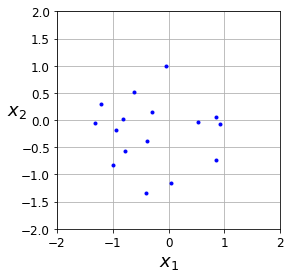

Epoch 000: Loss: 2.773, Accuracy: 8.000%
Epoch 500: Loss: 2.717, Accuracy: 4.000%
counter 100:
[0.00789868366 -0.111980908]
Time for epoch 100,
counter 200:
[-0.0319707692 -0.255562365]
Time for epoch 200,
counter 300:
[-0.132505715 -0.393277705]
Time for epoch 300,
counter 400:
[-0.293909 -0.264461875]
Time for epoch 400,
counter 500:
[-0.299279511 0.0547837466]
Time for epoch 500,
counter 600:
[-0.18485938 0.216816157]
Time for epoch 600,
counter 700:
[0.848186731 -0.378201187]
Time for epoch 700,
counter 800:
[0.202871636 0.785408497]
Time for epoch 800,
counter 900:
[1.10047328 0.1041006]
Time for epoch 900,
counter 1000:
[0.749882519 0.372624427]
Time for epoch 1000,
counter 1100:
[0.784199357 -0.136692435]
Time for epoch 1100,
counter 1200:
[0.690393388 0.0452442765]
Time for epoch 1200,
counter 1300:
[0.944294155 -0.123448677]
Time for epoch 1300,
counter 1400:
[0.94646132 -0.117749222]
Time for epoch 1400,
counter 1500:
[0.986179173 -0.299628735]
Time for epoch 1500,
counter 16

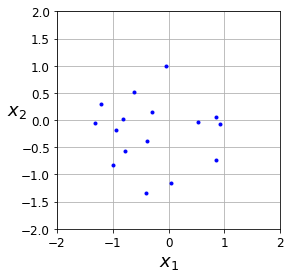

Epoch 000: Loss: 2.506, Accuracy: 28.000%
Epoch 500: Loss: 2.485, Accuracy: 44.000%
Epoch 1000: Loss: 2.485, Accuracy: 32.000%
Epoch 1500: Loss: 2.481, Accuracy: 36.000%


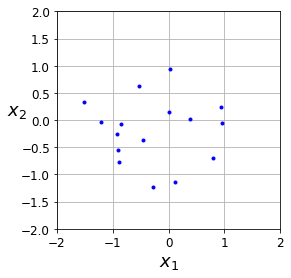

counter 100:
[-0.107051007 -0.495622903]
Time for epoch 100,
counter 200:
[-0.410747766 -0.595325589]
Time for epoch 200,
counter 300:
[-0.328209966 -0.609816253]
Time for epoch 300,
counter 400:
[-0.516312 -0.560915411]
Time for epoch 400,
counter 500:
[-0.160703868 -0.649624527]
Time for epoch 500,
counter 600:
[-0.303102732 -0.641532362]
Time for epoch 600,
counter 700:
[-0.32447058 -0.514708579]
Time for epoch 700,
counter 800:
[-0.517972589 -0.574447334]
Time for epoch 800,
counter 900:
[-0.349812299 -0.552249312]
Time for epoch 900,
counter 1000:
[-0.497134775 -0.593200326]
Time for epoch 1000,
counter 1100:
[-0.180381417 -0.604092181]
Time for epoch 1100,
counter 1200:
[-0.371047378 -0.66219]
Time for epoch 1200,
counter 1300:
[-0.785820067 -0.15041256]
Time for epoch 1300,
counter 1400:
[-0.158451468 -0.709515929]
Time for epoch 1400,
counter 1500:
[-0.223535597 -0.509716749]
Time for epoch 1500,
counter 1600:
[-0.211806297 -0.577253222]
Time for epoch 1600,
counter 1700:
[-0.4

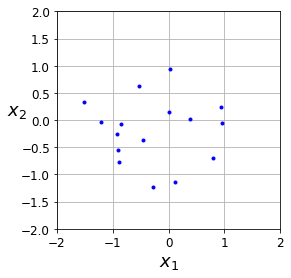

Epoch 000: Loss: 2.722, Accuracy: 26.000%
Epoch 500: Loss: 2.410, Accuracy: 28.000%
counter 100:
[-0.977808356 -1.08107984]
Time for epoch 100,
counter 200:
[-0.75894 -1.02372515]
Time for epoch 200,
counter 300:
[-0.395256 -1.0815618]
Time for epoch 300,
counter 400:
[-0.699174 -1.16303599]
Time for epoch 400,
counter 500:
[-0.781370223 -1.02623618]
Time for epoch 500,
counter 600:
[-0.421292275 -0.988834918]
Time for epoch 600,
counter 700:
[-0.353841603 -1.15435731]
Time for epoch 700,
counter 800:
[-0.4367 -1.25337875]
Time for epoch 800,
counter 900:
[-0.657447398 -0.922176838]
Time for epoch 900,
counter 1000:
[-0.787687778 -1.24237764]
Time for epoch 1000,
counter 1100:
[-0.537422955 -1.21226823]
Time for epoch 1100,
counter 1200:
[-0.749159873 -1.21184123]
Time for epoch 1200,
counter 1300:
[-0.385051 -1.28197968]
Time for epoch 1300,
counter 1400:
[-0.502141178 -1.13358355]
Time for epoch 1400,
counter 1500:
[-0.560651958 -1.30985308]
Time for epoch 1500,
counter 1600:
[-0.872

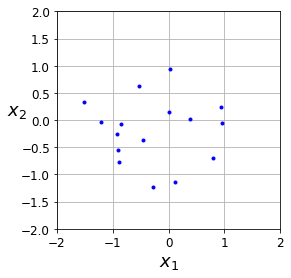

Epoch 000: Loss: 2.426, Accuracy: 42.000%
Epoch 500: Loss: 2.344, Accuracy: 53.000%
Epoch 1000: Loss: 2.354, Accuracy: 36.000%
Epoch 1500: Loss: 2.345, Accuracy: 47.000%


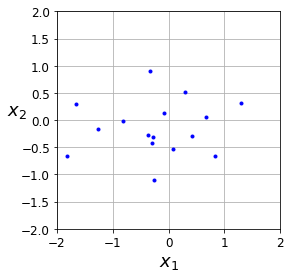

counter 100:
[0.200719237 -0.661587715]
Time for epoch 100,
counter 200:
[0.377186477 -0.884827435]
Time for epoch 200,
counter 300:
[0.117350295 -0.759282947]
Time for epoch 300,
counter 400:
[0.0822986215 -0.670722425]
Time for epoch 400,
counter 500:
[0.276236951 -0.856380045]
Time for epoch 500,
counter 600:
[0.299747497 -0.785599291]
Time for epoch 600,
counter 700:
[0.193367183 -0.862670302]
Time for epoch 700,
counter 800:
[0.244310275 -0.601285934]
Time for epoch 800,
counter 900:
[0.189461604 -0.720464647]
Time for epoch 900,
counter 1000:
[0.456109822 -0.625015736]
Time for epoch 1000,
counter 1100:
[-0.0579543076 -0.56145668]
Time for epoch 1100,
counter 1200:
[0.289698869 -0.804127812]
Time for epoch 1200,
counter 1300:
[0.219836786 -0.73034]
Time for epoch 1300,
counter 1400:
[0.493205398 -0.813961]
Time for epoch 1400,
counter 1500:
[0.343153507 -0.772948265]
Time for epoch 1500,
counter 1600:
[0.262616158 -0.967006683]
Time for epoch 1600,
counter 1700:
[0.280350626 -0.6

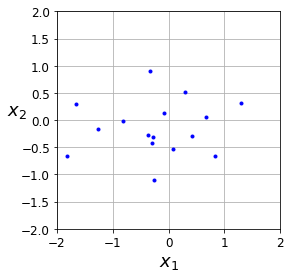

Epoch 000: Loss: 2.327, Accuracy: 46.000%
Epoch 500: Loss: 2.314, Accuracy: 45.000%
counter 100:
[0.195433199 -0.243682742]
Time for epoch 100,
counter 200:
[0.546271563 -0.0204431601]
Time for epoch 200,
counter 300:
[0.742683768 -0.171850428]
Time for epoch 300,
counter 400:
[0.663302243 -0.285624385]
Time for epoch 400,
counter 500:
[0.801114857 -0.0902744532]
Time for epoch 500,
counter 600:
[0.453746855 -0.0289775599]
Time for epoch 600,
counter 700:
[0.424520493 -0.0145323323]
Time for epoch 700,
counter 800:
[0.690945625 -0.0974878892]
Time for epoch 800,
counter 900:
[0.587684572 -0.197804123]
Time for epoch 900,
counter 1000:
[0.65689671 -0.0795123]
Time for epoch 1000,
counter 1100:
[0.71195364 -0.283876032]
Time for epoch 1100,
counter 1200:
[0.523183882 -0.2115]
Time for epoch 1200,
counter 1300:
[0.282706797 -0.0121878395]
Time for epoch 1300,
counter 1400:
[0.576879144 -0.137743518]
Time for epoch 1400,
counter 1500:
[0.642480075 -0.299847573]
Time for epoch 1500,
counter

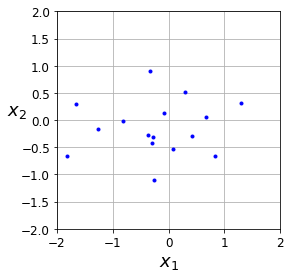

Epoch 000: Loss: 2.264, Accuracy: 47.000%
Epoch 500: Loss: 2.243, Accuracy: 51.000%
Epoch 1000: Loss: 2.251, Accuracy: 59.000%
Epoch 1500: Loss: 2.245, Accuracy: 55.000%


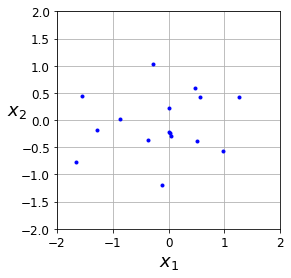

counter 100:
[0.278193474 -1.15840697]
Time for epoch 100,
counter 200:
[0.251828104 -0.983374298]
Time for epoch 200,
counter 300:
[0.480487198 -0.848803818]
Time for epoch 300,
counter 400:
[0.502243698 -0.919929]
Time for epoch 400,
counter 500:
[0.244650617 -1.17379892]
Time for epoch 500,
counter 600:
[0.152509838 -1.05289292]
Time for epoch 600,
counter 700:
[0.256281585 -0.752986193]
Time for epoch 700,
counter 800:
[0.595912576 -1.04655623]
Time for epoch 800,
counter 900:
[0.419770598 -0.810609221]
Time for epoch 900,
counter 1000:
[0.598723948 -0.932222307]
Time for epoch 1000,
counter 1100:
[0.355772555 -0.756833375]
Time for epoch 1100,
counter 1200:
[0.534080744 -1.18442595]
Time for epoch 1200,
counter 1300:
[0.456302762 -0.659773827]
Time for epoch 1300,
counter 1400:
[0.406327099 -1.15486646]
Time for epoch 1400,
counter 1500:
[0.197769374 -0.988777578]
Time for epoch 1500,
counter 1600:
[0.323849916 -1.02927315]
Time for epoch 1600,
counter 1700:
[0.502447367 -1.261654

In [24]:
%%time
generator_optimizer, discriminator_optimizer = gan_optimizers(gen_learning_rate=gen_learning_rate, disc_learning_rate = disc_learning_rate)
start = time.time()

for i in range(3):
  test_encoding(M,n)
  decoder_training(501, 100)
  creating_and_train_gan(epochs= 2000,n_steps=5, batch_size =100, SNR_level = 7, n = n)
  decoder_training(2001, 100)
  #encoder_training(501,100)
  test_encoding(M,n)
  encoder_training(1501,100)
  test_encoding(M,n)
  creating_and_train_gan(epochs= 2000,n_steps=5, batch_size =100, SNR_level = 7, n = n)

time_to_train_gan = time.time()-start
tf.print ('Time for the training is {} sec,'.format( time.time()-start))

Train on 10000000 samples
Epoch 1/20
   96000/10000000 [..............................] - ETA: 1:50 - loss: 0.1632 - accuracy: 0.9420

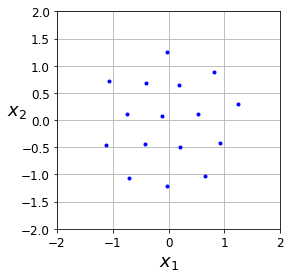

CPU times: user 31.5 s, sys: 1.04 s, total: 32.5 s
Wall time: 25.3 s


In [25]:
%%time
generator.trainable =False
encoder.trainable = True
decoder.trainable = True
gan_AE = tf.keras.models.Sequential([encoder,generator,decoder])
data = random_sample(10000000)
start = time.time()
gan_AE.compile(optimizer=keras.optimizers.Nadam(lr=0.0005),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = gan_AE.fit(data, data, batch_size=500,steps_per_epoch=200, epochs=20)

test_encoding(M,n)


# AE training

In [0]:
# test msg sequence for normal encoding
N_test = 500000
test_msg = np.random.randint(M, size=N_test)

### Comparison

In [27]:
gan_bber_data = gan_Test_AE(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


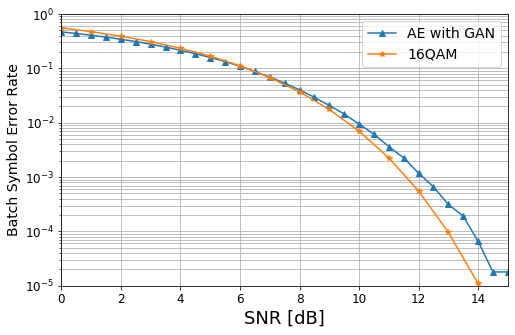

In [28]:
# Approximate 16 QAM Error
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], '^-')
plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '*-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['AE with GAN', '16QAM'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")
#print('time to train the AE Model with GAN',time_to_train_gan)


In [29]:
bber_data_rayleigh = Test_AE_rayleigh(test_msg)

Progress: 6 of 30 parts
Progress: 12 of 30 parts
Progress: 18 of 30 parts
Progress: 24 of 30 parts
Progress: 30 of 30 parts


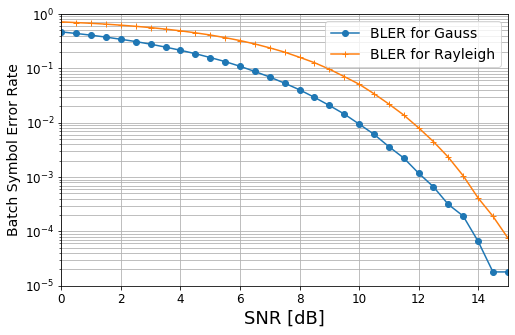

In [30]:
def SIXT_QAM_sim(ebno):
    return (3.0/2)*special.erfc(np.sqrt((4.0/10)*10.**(ebno/10)))

ebnodbs = np.linspace(0,15,16)
fig = plt.figure(figsize=(8, 5))
plt.semilogy(gan_bber_data[0], gan_bber_data[1], 'o-')
plt.semilogy(bber_data_rayleigh[0], bber_data_rayleigh[1], '+-')
#plt.semilogy(ebnodbs, SIXT_QAM_sim(ebnodbs), '^-');
plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(0, 15)
plt.ylabel("Batch Symbol Error Rate", fontsize=14, rotation=90)
plt.xlabel("SNR [dB]", fontsize=18)
plt.legend(['BLER for Gauss','BLER for Rayleigh'],
           prop={'size': 14}, loc='upper right');
plt.grid(True, which="both")
#plt.savefig('home/ben/Downloads/MineRayleigh.eps', format='eps')